In [16]:
import pandas as pd
from zipfile import ZipFile
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
import matplotlib.patches as mpatches

In [2]:
#Downloaing the data using the Kaggle API
!kaggle datasets download -d timoboz/tesla-stock-data-from-2010-to-2020

#Extracting the zip file
with ZipFile('tesla-stock-data-from-2010-to-2020.zip', 'r') as zip:
    zip.extractall()

tesla-stock-data-from-2010-to-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
#Reading the data
df_tesla = pd.read_csv('TSLA.csv')

#Converting to datetime
df_tesla['Date']= pd.to_datetime(df_tesla['Date'])

Text(0.5, 1.0, 'Tesla Stock Close Price vs. Time')

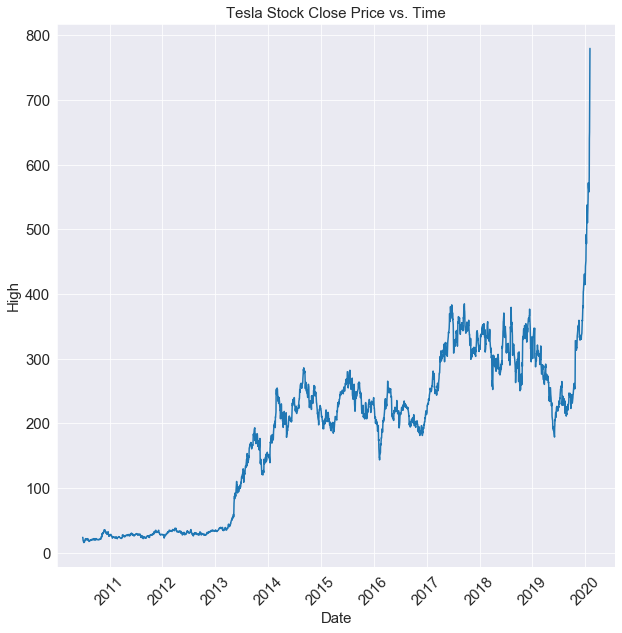

In [7]:
plt.figure(figsize = (10,10))
sns.set_style('darkgrid')

#I'll only plot for the CLose column - any column will give pretty much the same graph (except Volume)
sns.lineplot(data=df_tesla, x = "Date", y = "Close")


#Axes adjustment
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Date', fontsize = 15)

plt.yticks(fontsize = 15)
plt.ylabel('High', fontsize = 15)

plt.title("Tesla Stock Close Price vs. Time", fontsize = 15)

In [8]:
#Importing Elon Musks Tweets
df_musk_tweets = pd.read_json('https://query.data.world/s/r5n6qf6m2h4xzmw5tfejz44tsgq35z', lines = True)

#Transforming the CreatedAt column into proper datetime format
df_split = df_musk_tweets["CreatedAt"].str.split(" ", n = 3, expand = True) 
df_musk_tweets['Month'] = df_split[0]
df_musk_tweets['Day'] = df_split[1]
df_musk_tweets['Year'] = df_split[2]

di = {calendar.month_name[1]: '01',
      calendar.month_name[2]: '02',
      calendar.month_name[3]: '03',
      calendar.month_name[4]: '04',
      calendar.month_name[5]: '05',
      calendar.month_name[6]: '06',
      calendar.month_name[7]: '07',
      calendar.month_name[8]: '08', 
      calendar.month_name[9]: '09',
      calendar.month_name[10]: '10',
      calendar.month_name[11]: '11',
      calendar.month_name[12]: '12'}

df_musk_tweets["Month"].replace(di, inplace=True)

#I will count the number of tweets by month, as by day will make the plot too noisy
df_musk_tweets['datetime'] = df_musk_tweets['Month'] + ',' + df_musk_tweets['Year']

df_musk_tweets['datetime'] = pd.to_datetime(df_musk_tweets['datetime'], format= '%m,%Y')

#Dropping unecessary columns
df_musk_tweets.drop(columns = ['Month', 'Day', 'Year', 'TweetEmbedCode', 'LinkToTweet', 'UserName', 'CreatedAt'], inplace = True)

Text(0.5, 1.0, 'Elon Musk Number of Tweets vs. Time')

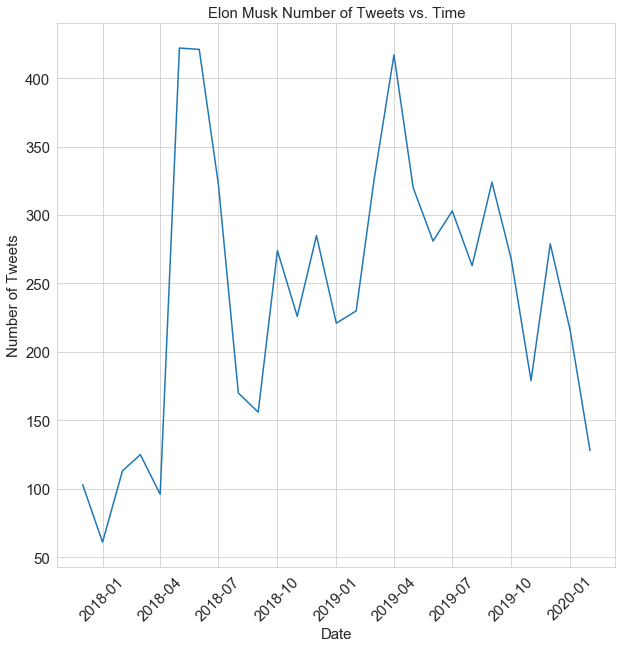

In [10]:
#Plotting his number of tweets over time
df_musk_tweets_plot = df_musk_tweets.groupby('datetime').agg('count').reset_index()


plt.figure(figsize = (10,10))
sns.set_style('whitegrid')

sns.lineplot(data=df_musk_tweets_plot, x = "datetime", y = "Text")


#Axes adjustment
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Date', fontsize = 15)

plt.yticks(fontsize = 15)
plt.ylabel('Number of Tweets', fontsize = 15)

plt.title("Elon Musk Number of Tweets vs. Time", fontsize = 15)

# Now combining both plots

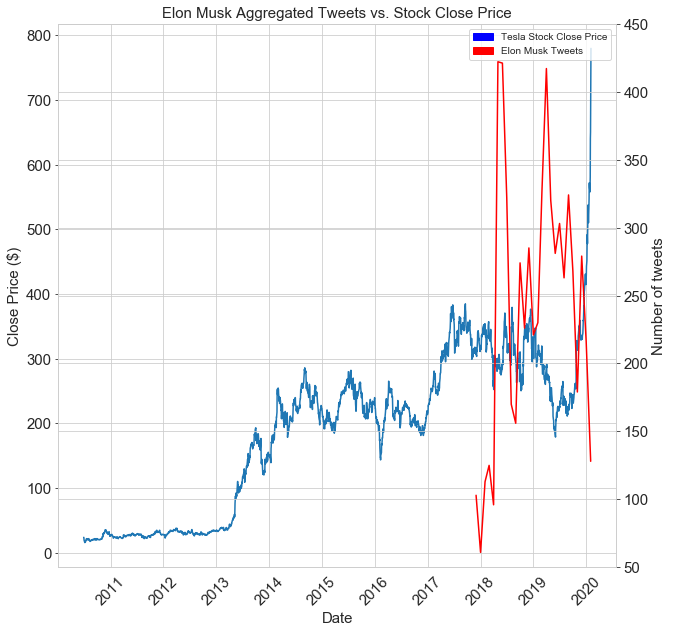

In [19]:
#Creating a figure
plt.figure(figsize = (10,10))
sns.set_style('whitegrid')

#Plotting the first plot
sns.lineplot(data=df_tesla, x = "Date", y = "Close")
plt.ylabel('Close Price ($)', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Date', fontsize = 15)


#Plotting the second plot
ax2 = plt.twinx()
sns.lineplot(data=df_musk_tweets_plot, x = "datetime", y = "Text", color = 'red')
plt.ylabel('Number of tweets', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(50, 450)

#Axes adjustment
plt.xticks(fontsize = 20)
plt.title('Elon Musk Aggregated Tweets vs. Stock Close Price', fontsize = 15)

#Adding custom legends
red_patch = mpatches.Patch(color='red', label='Elon Musk Tweets')
blue_patch = mpatches.Patch(color='blue', label='Tesla Stock Close Price')


plt.legend(handles=[blue_patch, red_patch])

# Now let's try some basic sentiment analysis

## This is a code to create the function for the sentiment analysis - it includes the following steps:
- Step 1 — Installing NLTK and Downloading the Data
- Step 2 — Tokenizing the Data (splitting it up into distinct parts)
- Step 3 — Normalizing the Data (simplifying run, ran, running, etc.)
- Step 4 — Removing Noise from the Data
- Step 5 — Determining Word Density
- Step 6 — Preparing Data for the Model
- Step 7 — Building and Testing the Model (Naiive Bayes Classifier)

In [13]:
#Code for sentiment analysis

#Installing the necessary packages
import nltk
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
 
import re, string, random
 
def remove_noise(tweet_tokens, stop_words = ()):
 
    cleaned_tokens = []
 
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
 
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
 
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
 
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
 
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

if __name__ == "__main__":
    
    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    text = twitter_samples.strings('tweets.20150430-223406.json')
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]
 
    stop_words = stopwords.words('english')
 
    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
 
    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []
 
    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))
 
    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))
 
    all_pos_words = get_all_words(positive_cleaned_tokens_list)
 
    freq_dist_pos = FreqDist(all_pos_words)
    print(freq_dist_pos.most_common(10))
 
    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)
 
    positive_dataset = [(tweet_dict, "Positive")
                         for tweet_dict in positive_tokens_for_model]
 
    negative_dataset = [(tweet_dict, "Negative")
                         for tweet_dict in negative_tokens_for_model]
 
    dataset = positive_dataset + negative_dataset
 
    random.shuffle(dataset)
 
    train_data = dataset[:7000]
    test_data = dataset[7000:]
 
    classifier = NaiveBayesClassifier.train(train_data)
 
    print("Accuracy is:", classify.accuracy(classifier, test_data))
 
    print(classifier.show_most_informative_features(10))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dulur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
Accuracy is: 0.9963333333333333
Most Informative Features
                      :( = True           Negati : Positi =   2082.2 : 1.0
                      :) = True           Positi : Negati =    995.2 : 1.0
                     sad = True           Negati : Positi =     26.9 : 1.0
                followed = True           Negati : Positi =     23.4 : 1.0
                follower = True           Positi : Negati =     22.6 : 1.0
                    glad = True           Positi : Negati =     22.6 : 1.0
                  arrive = True           Positi : Negati =     20.2 : 1.0
                     bam = True           Positi : Negati =     17.4 : 1.0
                     x15 = True 

In [14]:
#Running the model onto our tweets

df_musk_tweets['Sentiment'] = np.NaN
uniquetexts = df_musk_tweets.Text.unique()

for i in range(len(uniquetexts)):
    
    custom_tweet = uniquetexts[i]
    custom_tokens = remove_noise(word_tokenize(custom_tweet))
    x = classifier.classify(dict([token, True] for token in custom_tokens))
    
    df_musk_tweets.loc[df_musk_tweets['Text'] == uniquetexts[i], 'Sentiment'] = x
    

# Now let's plot the positive and negative tweets separately

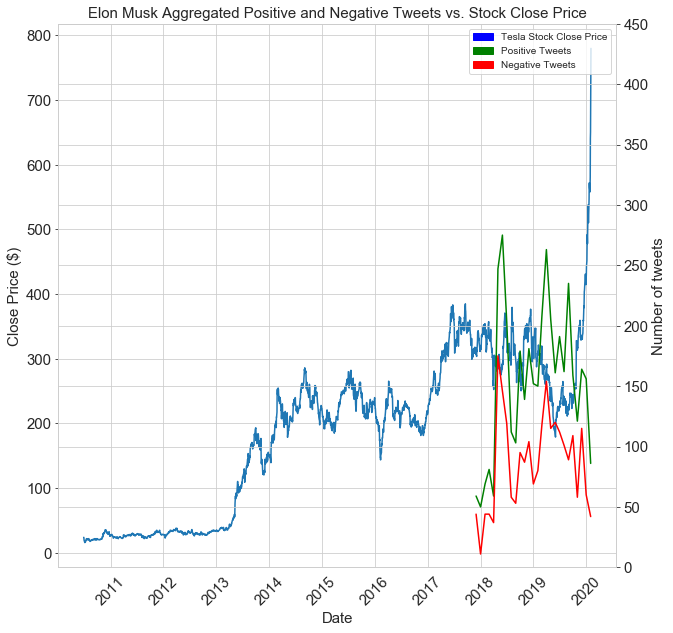

In [18]:
#Plotting his number of tweets over time
df_musk_tweets_plot_positive = df_musk_tweets.loc[df_musk_tweets['Sentiment'] == 'Positive'].groupby('datetime').agg('count').reset_index()
df_musk_tweets_plot_negative = df_musk_tweets.loc[df_musk_tweets['Sentiment'] == 'Negative'].groupby('datetime').agg('count').reset_index()

#Creating a figure
plt.figure(figsize = (10,10))
sns.set_style('whitegrid')

#Plotting the first plot
sns.lineplot(data=df_tesla, x = "Date", y = "Close")
plt.ylabel('Close Price ($)', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(rotation = 45, fontsize = 15)
plt.xlabel('Date', fontsize = 15)


#Plotting the second plot
ax2 = plt.twinx()
sns.lineplot(data=df_musk_tweets_plot_positive, x = "datetime", y = "Text", color = 'green')
plt.ylabel('Number of tweets', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(50, 450)


#Plotting the third plot
sns.lineplot(data=df_musk_tweets_plot_negative, x = "datetime", y = "Text", color = 'red')
plt.ylabel('Number of tweets', fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(0, 450)


#Axes adjustment
plt.xticks(fontsize = 20)
plt.title('Elon Musk Aggregated Positive and Negative Tweets vs. Stock Close Price', fontsize = 15)

#Adding custom legends
red_patch = mpatches.Patch(color='red', label='Negative Tweets')
blue_patch = mpatches.Patch(color='blue', label='Tesla Stock Close Price')
green_patch = mpatches.Patch(color='green', label='Positive Tweets')


plt.legend(handles=[blue_patch, green_patch, red_patch])

# Discussion

- From this work, we can see that this is no clear correlation between Elon Musk's tweets and his stock prices.